In [1]:
!pip install kaggle -q

!mkdir -p ~/.kaggle
from google.colab import files
files.upload()  # upload kaggle.json

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kkhandekar/word-difficulty
!unzip -o word-difficulty.zip -d word_difficulty

!ls word_difficulty

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kkhandekar/word-difficulty
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/751k [00:00<?, ?B/s]
100% 751k/751k [00:00<00:00, 1.09GB/s]
Archive:  word-difficulty.zip
  inflating: word_difficulty/WordDifficulty.csv  
WordDifficulty.csv


In [16]:
import os
import shutil
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Concatenate, Layer, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

# Config
pd.set_option('display.max_colwidth', None)
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
# ======================================================
# 1. XỬ LÝ DỮ LIỆU
# ======================================================

data = pd.read_csv("word_difficulty/WordDifficulty.csv")
data = data.dropna()
data["Word"] = data["Word"].str.lower().str.replace("'", "", regex=False)

# --- LỌC NHIỄU ---
data = data[~((data['Word'].str.len() == 1) & (~data['Word'].isin(['a', 'i'])))]
print(f"Số lượng dữ liệu sau khi lọc nhiễu: {len(data)}")

# Gán nhãn độ khó
data["Difficulty"] = 0
data.loc[data["I_Zscore"] > -0.3, "Difficulty"] = 1
data.loc[data["I_Zscore"] > 0.3, "Difficulty"] = 2

x_words = data["Word"].values
y = data["Difficulty"].values

# --- LẤY DỮ LIỆU TẦN SUẤT ---
x_freq = data["Log_Freq_HAL"].values.reshape(-1, 1)

# --- A. Tokenizer Ký tự & Từ ---
def create_char_vocab(words):
    chars = sorted(set("".join(words)))
    vocab = {c: i+1 for i, c in enumerate(chars)}
    return vocab, len(vocab) + 1

def encode_chars(words, vocab, maxlen=21):
    seqs = [[vocab.get(c, 0) for c in w] for w in words]
    return pad_sequences(seqs, maxlen=maxlen, padding="post")

char_vocab, char_vocab_size = create_char_vocab(x_words)
X_char = encode_chars(x_words, char_vocab, maxlen=21)

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_words)
X_word_seq = word_tokenizer.texts_to_sequences(x_words)
X_word_idx = np.array([i[0] for i in X_word_seq])
word_vocab_size = len(word_tokenizer.word_index) + 1

# --- B. FEATURE ENGINEERING ---
def count_syllables(word):
    word = str(word).lower()
    count = 0
    vowels = "aeiouy"
    if len(word) == 0: return 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def extract_features_basic(words):
    features = []
    vowels = set("aeiou")
    for w in words:
        w = str(w)
        length = len(w)
        num_vowels = sum(1 for c in w if c in vowels)
        syllables = count_syllables(w)
        consonant_ratio = (length - num_vowels) / length if length > 0 else 0

        features.append([length, num_vowels, syllables, consonant_ratio])
    return np.array(features)

print("Đang trích xuất đặc trưng thủ công...")
X_basic = extract_features_basic(x_words)

# --- GỘP ĐẶC TRƯNG ---
X_manual = np.hstack((X_basic, x_freq))

# Chuẩn hóa
scaler = StandardScaler()
X_manual = scaler.fit_transform(X_manual)

print("Shape Char:", X_char.shape)
print("Shape Word:", X_word_idx.shape)
print("Shape Manual Features:", X_manual.shape)

# --- Chia tập Train/Test ---
X_char_train, X_char_test, X_word_train, X_word_test, X_man_train, X_man_test, Y_train, Y_test = train_test_split(
    X_char, X_word_idx, X_manual, y, test_size=0.2, random_state=42
)

Số lượng dữ liệu sau khi lọc nhiễu: 40449
Đang trích xuất đặc trưng thủ công...
Shape Char: (40449, 21)
Shape Word: (40449,)
Shape Manual Features: (40449, 5)


In [21]:
# ======================================================
# 2. XÂY DỰNG MODEL
# ======================================================

# --- Custom Attention ---
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        return tf.keras.backend.sum(x * a, axis=1)

# 1. Nhánh Ký tự: CNN + Bi-LSTM
input_char = Input(shape=(21,), name="Input_Char")
emb_char = Embedding(char_vocab_size, 32, trainable=True)(input_char)
conv_char = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(emb_char)
conv_char = BatchNormalization()(conv_char)
bi_lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5))(conv_char)
att_char = Attention()(bi_lstm)
char_feat = Dropout(0.5)(att_char)

# 2. Nhánh Từ: Embedding
input_word = Input(shape=(1,), name="Input_Word")
emb_word = Embedding(word_vocab_size, 64, trainable=True)(input_word)
flat_word = Flatten()(emb_word)
word_feat = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(flat_word)
word_feat = Dropout(0.5)(word_feat)

# 3. Nhánh Thủ công (Manual Features)
input_man = Input(shape=(5,), name="Input_Manual")
man_feat = Dense(16, activation="relu")(input_man)
man_feat = BatchNormalization()(man_feat)

# 4. Kết hợp 3 nhánh
merged = Concatenate()([char_feat, word_feat, man_feat])

z = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(merged)
z = BatchNormalization()(z)
z = Dropout(0.5)(z)

z = Dense(32, activation="relu", kernel_regularizer=l2(0.01))(z)
z = Dropout(0.3)(z)

# Output
output = Dense(1, activation="linear", name="Output_Score")(z)

model = Model(inputs=[input_char, input_word, input_man], outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=tf.keras.losses.Huber(delta=1.0),
              metrics=["mae"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Char          │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 21, 32)    │        864 │ Input_Char[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 21, 64)    │      6,208 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Word          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 64)     │  2,558,272 │ Input_Word[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 21, 128)   │     66,048 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 64)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Manual        │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 128)       │        149 │ bidirectional_3[… │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │         96 │ Input_Manual[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ attention_3[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 208)       │          0 │ dropout_12[0][0], │
│ (Concatenate)       │                   │            │ dropout_13[0][0], │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     13,376 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,651,862 (10.12 MB)

 Trainable params: 2,651,574 (10.11 MB)

 Non-trainable params: 288 (1.12 KB)

In [22]:
# ======================================================
# 3. HUẤN LUYỆN MODEL
# ======================================================

# --- Callback 1: Warmup Learning Rate ---
class WarmupScheduler(tf.keras.callbacks.Callback):
    def __init__(self, warmup_epochs=5, target_lr=1e-4):
        super(WarmupScheduler, self).__init__()
        self.warmup_epochs = warmup_epochs
        self.target_lr = target_lr

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            current_lr = self.target_lr * ((epoch + 1) / self.warmup_epochs)

            if hasattr(self.model.optimizer, 'learning_rate'):
                self.model.optimizer.learning_rate.assign(current_lr)
            else:
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr)

            print(f"\nWarmup: Tăng Learning Rate lên {current_lr:.2e}")

# --- Callback 2: Custom Early Stopping ---
class CustomEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def on_train_end(self, logs=None):
        super().on_train_end(logs)
        if self.stopped_epoch > 0:
            print("\n" + "="*50)
            print(f"🛑 EARLY STOPPING KÍCH HOẠT TẠI EPOCH {self.stopped_epoch + 1}")
            print("="*50 + "\n")

# --- TỔNG HỢP CALLBACKS ---
callbacks = [
    WarmupScheduler(warmup_epochs=5, target_lr=1e-4),
    CustomEarlyStopping(monitor='val_mae', patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, verbose=1)
]

print("\nBắt đầu training...")

# Khởi tạo giá trị ban đầu
if hasattr(model.optimizer, 'learning_rate'):
    model.optimizer.learning_rate.assign(1e-6)
else:
    model.optimizer.lr.assign(1e-6)

history = model.fit(
    [X_char_train, X_word_train, X_man_train],
    Y_train,
    validation_data=([X_char_test, X_word_test, X_man_test], Y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)


Bắt đầu training...

Warmup: Tăng Learning Rate lên 2.00e-05
Epoch 1/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 2.9136 - mae: 1.3262 - val_loss: 2.1496 - val_mae: 0.6347 - learning_rate: 2.0000e-05

Warmup: Tăng Learning Rate lên 4.00e-05
Epoch 2/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 2.3962 - mae: 0.9914 - val_loss: 1.8795 - val_mae: 0.6611 - learning_rate: 4.0000e-05

Warmup: Tăng Learning Rate lên 6.00e-05
Epoch 3/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1.9194 - mae: 0.8179 - val_loss: 1.5395 - val_mae: 0.7025 - learning_rate: 6.0000e-05

Warmup: Tăng Learning Rate lên 8.00e-05
Epoch 4/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1.4599 - mae: 0.7103 - val_loss: 1.1653 - val_mae: 0.6735 - learning_rate: 8.0000e-05

Warmup: Tăng Learning Rate lên 1.00e-04
Epoch 5/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 1.0576 - mae: 0.6309 - val_loss: 0.8387 - val_mae: 0.6104 - learning_rate: 1.0000e-04
Epoch 6/100
506/506 ━━━━━━━━━━━━━

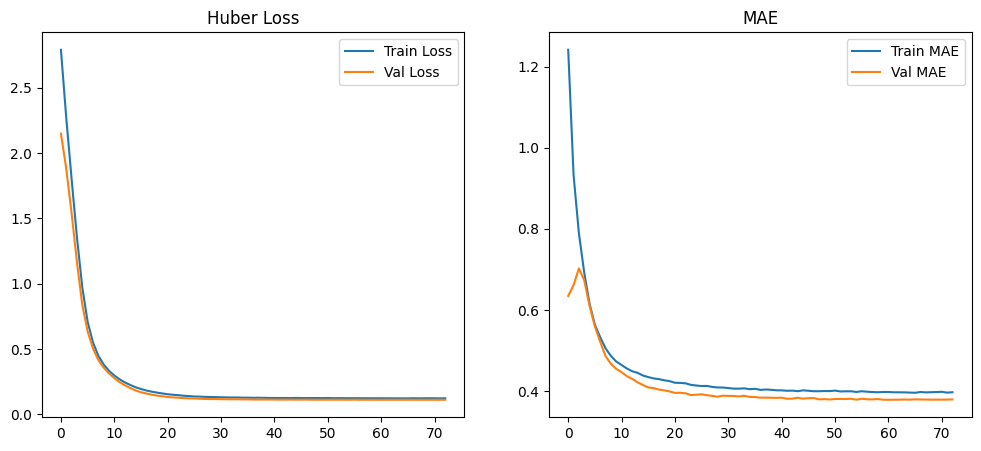


🔍 Đang tìm ngưỡng tối ưu (Standardized Search)...
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Thống kê điểm dự đoán: Min=-0.179, Max=2.328, Mean=0.958

✅ KẾT QUẢ TỐI ƯU:
   Accuracy: 71.06%
   Ngưỡng tối ưu: 0.46 - 1.52

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.80      0.65      0.72      2392
           1       0.66      0.81      0.72      3757
           2       0.77      0.59      0.67      1941

    accuracy                           0.71      8090
   macro avg       0.74      0.68      0.70      8090
weighted avg       0.72      0.71      0.71      8090



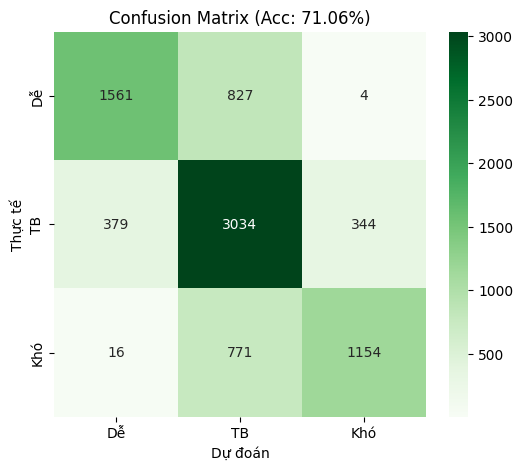

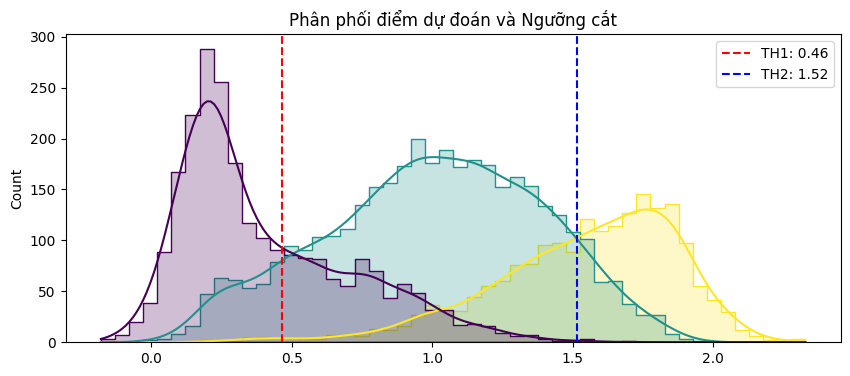

In [23]:
# ======================================================
# 5. ĐÁNH GIÁ & TỐI ƯU HÓA
# ======================================================

# 1. Vẽ biểu đồ Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f'Huber Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title(f'MAE')
plt.legend()
plt.show()

# 2. Dự đoán Raw Score
print("\n🔍 Đang tìm ngưỡng tối ưu (Standardized Search)...")
pred_raw = model.predict([X_char_test, X_word_test, X_man_test]).flatten()

print(f"Thống kê điểm dự đoán: Min={pred_raw.min():.3f}, Max={pred_raw.max():.3f}, Mean={pred_raw.mean():.3f}")

# Tạo lại nhãn thực tế (0, 1, 2) từ Z-score
y_true = Y_test

# 3. Thuật toán tìm ngưỡng (QUÉT RỘNG TỪ -2 ĐẾN 2)
best_acc = 0
best_th1, best_th2 = -0.3, 0.3 # Mặc định theo dataset

search_range = np.linspace(-2.0, 2.0, 100) # Quét 100 điểm từ -2 đến 2

for th1 in search_range:
    # th2 phải luôn lớn hơn th1 ít nhất 0.1 đơn vị
    for th2 in search_range:
        if th2 <= th1 + 0.1: continue

        pred_temp = np.zeros_like(pred_raw)
        pred_temp[pred_raw >= th1] = 1
        pred_temp[pred_raw >= th2] = 2

        acc = accuracy_score(y_true, pred_temp)
        if acc > best_acc:
            best_acc = acc
            best_th1, best_th2 = th1, th2

print(f"\n✅ KẾT QUẢ TỐI ƯU:")
print(f"   Accuracy: {best_acc*100:.2f}%")
print(f"   Ngưỡng tối ưu: {best_th1:.2f} - {best_th2:.2f}")

# 4. Báo cáo chi tiết
final_pred = np.zeros_like(pred_raw)
final_pred[pred_raw >= best_th1] = 1
final_pred[pred_raw >= best_th2] = 2

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, final_pred))

# 5. Confusion Matrix
cm = confusion_matrix(y_true, final_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Dễ', 'TB', 'Khó'], yticklabels=['Dễ', 'TB', 'Khó'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(f'Confusion Matrix (Acc: {best_acc*100:.2f}%)')
plt.show()

# 6. Biểu đồ phân phối điểm
plt.figure(figsize=(10, 4))
sns.histplot(x=pred_raw, hue=y_true, palette="viridis", kde=True, bins=50, element="step")
plt.axvline(best_th1, color='red', linestyle='--', label=f'TH1: {best_th1:.2f}')
plt.axvline(best_th2, color='blue', linestyle='--', label=f'TH2: {best_th2:.2f}')
plt.title("Phân phối điểm dự đoán và Ngưỡng cắt")
plt.legend()
plt.show()

In [25]:
# ======================================================
# 5. LƯU MODEL VÀ CÁC THAM SỐ CẤU HÌNH & TẢI XUỐNG
# ======================================================
from google.colab import files

print("\n💾 ĐANG LƯU MODEL BILSTM...")

model_name = "word_difficulty_bilstm.h5"
model.save(model_name)
print(f"✅ [1/5] Đã lưu Model: {model_name}")

with open("char_vocab.pkl", "wb") as f:
    pickle.dump(char_vocab, f)
print("✅ [2/5] Đã lưu: char_vocab.pkl")

with open("word_tokenizer.pkl", "wb") as f:
    pickle.dump(word_tokenizer, f)
print("✅ [3/5] Đã lưu: word_tokenizer.pkl")

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("✅ [4/5] Đã lưu: scaler.pkl")

threshold_data = {
    "th1": best_th1,
    "th2": best_th2
}
with open("thresholds.pkl", "wb") as f:
    pickle.dump(threshold_data, f)
print(f"✅ [5/5] Đã lưu: thresholds.pkl (Ngưỡng: {best_th1:.3f} - {best_th2:.3f})")

# --- B. NÉN FILE VÀ TẢI XUỐNG ---
print("\n📦 Đang nén tất cả vào file zip...")

# Danh sách các file cần nén
files_to_download = [
    model_name,
    "char_vocab.pkl",
    "word_tokenizer.pkl",
    "scaler.pkl",
    "thresholds.pkl"
]

zip_filename = "bilstm_artifacts.zip"
if os.path.exists(zip_filename):
    os.remove(zip_filename)

os.system(f"zip -r {zip_filename} {' '.join(files_to_download)}")

print(f"✅ Đã nén thành công: {zip_filename}")
print("⬇️ Đang bắt đầu tải xuống...")

try:
    files.download(zip_filename)
except Exception as e:
    print(f"⚠️ Không thể tự động tải (Lỗi: {e}).")
    print("👉 Hãy nhìn sang thanh bên trái (biểu tượng Thư mục), tìm file 'model_artifacts.zip', chuột phải và chọn Download.")


💾 ĐANG LƯU MODEL BILSTM...
✅ [1/5] Đã lưu Model: word_difficulty_bilstm.h5
✅ [2/5] Đã lưu: char_vocab.pkl
✅ [3/5] Đã lưu: word_tokenizer.pkl
✅ [4/5] Đã lưu: scaler.pkl
✅ [5/5] Đã lưu: thresholds.pkl (Ngưỡng: 0.465 - 1.515)

📦 Đang nén tất cả vào file zip...
✅ Đã nén thành công: bilstm_artifacts.zip
⬇️ Đang bắt đầu tải xuống...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>